In [1]:
import numpy as np
import os, sys
from glob import glob
from tqdm import tqdm
from time import time
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        'serif'  : ['Palatino'],
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
import pandas as pd
import pickle as pkl
import corner

def optimal_n_bins(y,max_bins=100):
    from scipy.stats import iqr
    n_bins = int((max(y) - min(y))/(2*iqr(y)*len(y)**(-1/3)))
    return min(n_bins,max_bins)

def print_stats(y):
    print(f'{np.mean(y):5.5} +/- {np.std(y):5.5}')
    
def make_hist(data,title_string,label):
    y = data.flatten()
    n_bins = 40
    plt.figure(figsize=(10,7))
    plt.hist(y,bins=n_bins,density=True)
    y_mean = np.mean(y)
    y_std = np.std(y)
    plt.title(f"{title_string}\n{y_mean:5.5} +/- {y_std:5.5}")
    plt.xlabel(label)
    plt.ylabel('Density (no units)')
    plt.xticks(rotation=45)
    plt.show()


In [2]:
g_sp_free = 5.5857
g_sn_free = - 3.8263
g_lp_free = 1.0
g_ln_free = 0.0
g_sp_brown = 5.15
g_sn_brown = - 3.55
g_lp_brown = 1.159
g_ln_brown = -0.09
g_sis_free = g_sp_free + g_sn_free
g_siv_free = g_sp_free - g_sn_free
g_lis_free = g_lp_free + g_ln_free
g_liv_free = g_lp_free - g_ln_free
g_sis_brown = g_sp_brown + g_sn_brown
g_siv_brown = g_sp_brown - g_sn_brown
g_lis_brown = g_lp_brown + g_ln_brown
g_liv_brown = g_lp_brown + g_ln_brown
g_list_brown = [g_sp_brown,g_sn_brown,g_lp_brown,g_ln_brown]

# v5.3 Gaussian priors, orbital isoscalar fixed

(3, 499200)


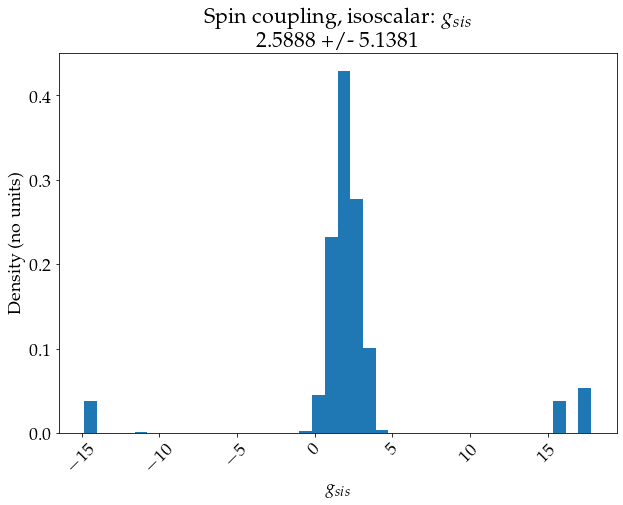

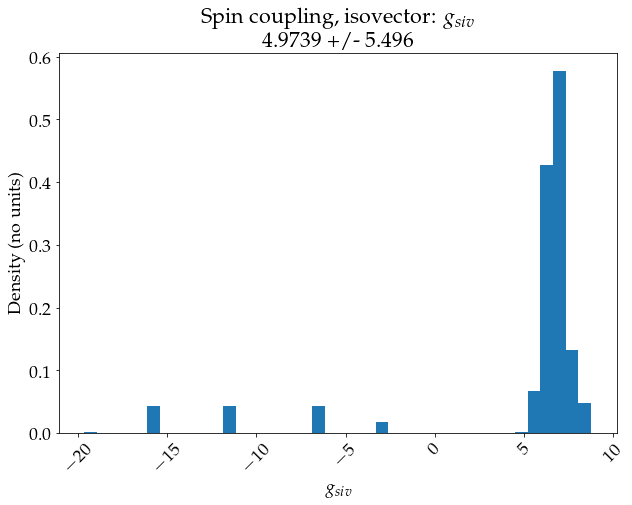

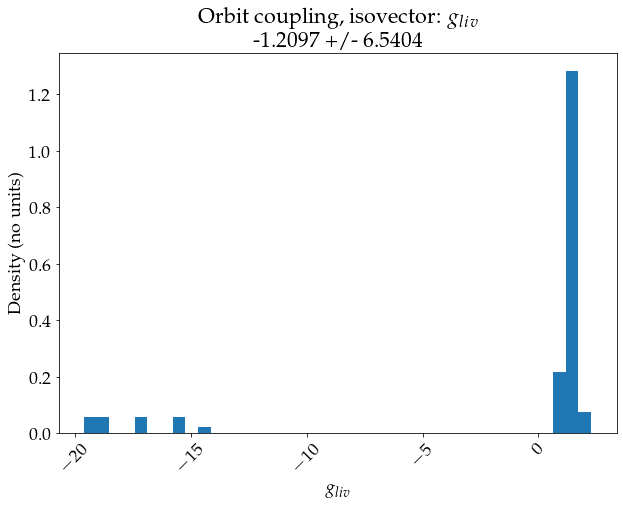

In [3]:
with open('traces_v5.3.pkl','rb') as fh:
    chain = pkl.load(fh)
    
warmup = 400
chain = chain[:,warmup:,:]
chain = np.reshape(chain.T,(3,-1))
print(chain.shape)

g_sis_trace = chain[0].flatten()
g_siv_trace = chain[1].flatten()
g_liv_trace = chain[2].flatten()

make_hist(g_sis_trace,r'Spin coupling, isoscalar: $g_{sis}$',r'$g_{sis}$')
make_hist(g_siv_trace,r'Spin coupling, isovector: $g_{siv}$',r'$g_{siv}$')
make_hist(g_liv_trace,r'Orbit coupling, isovector: $g_{liv}$',r'$g_{liv}$')

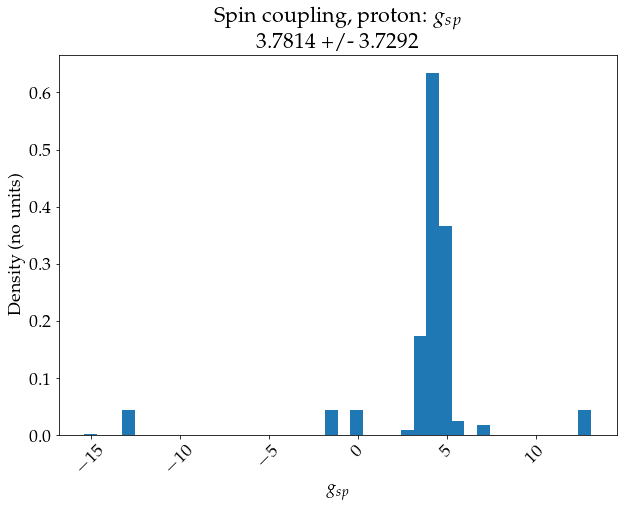

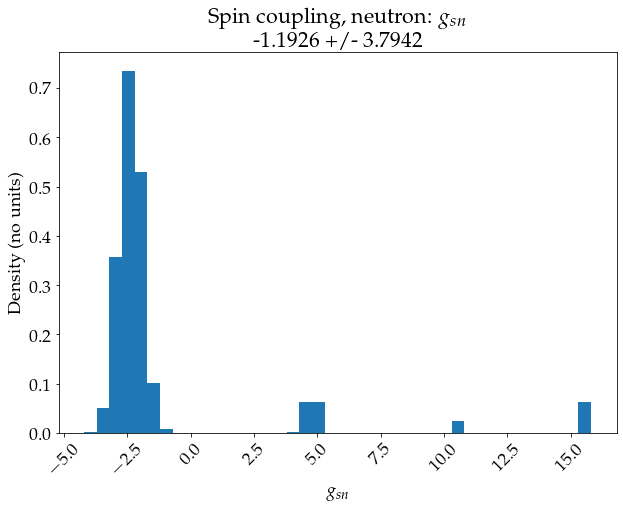

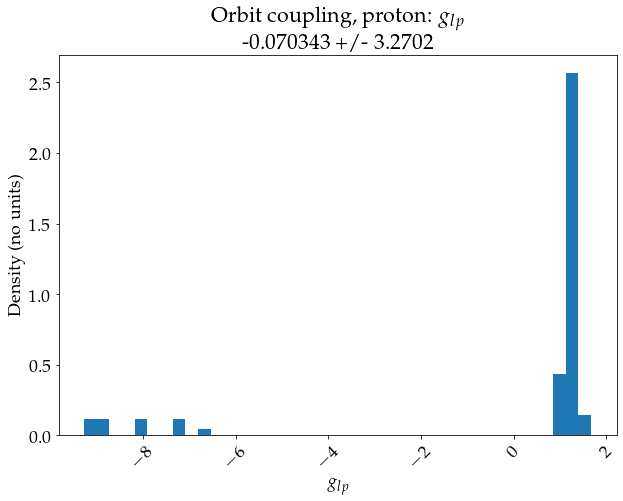

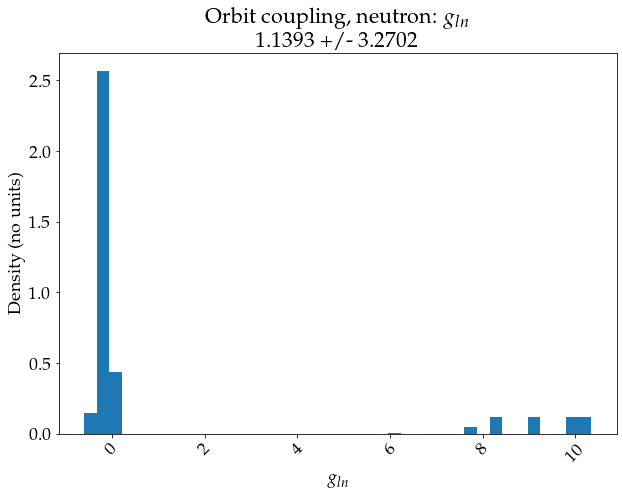

In [4]:
g_sp_trace = 0.5*(g_sis_trace + g_siv_trace)
g_sn_trace = 0.5*(g_sis_trace - g_siv_trace)
g_lp_trace = 0.5*(g_lis_brown + g_liv_trace)
g_ln_trace = 0.5*(g_lis_brown - g_liv_trace)

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

# Drop outliers

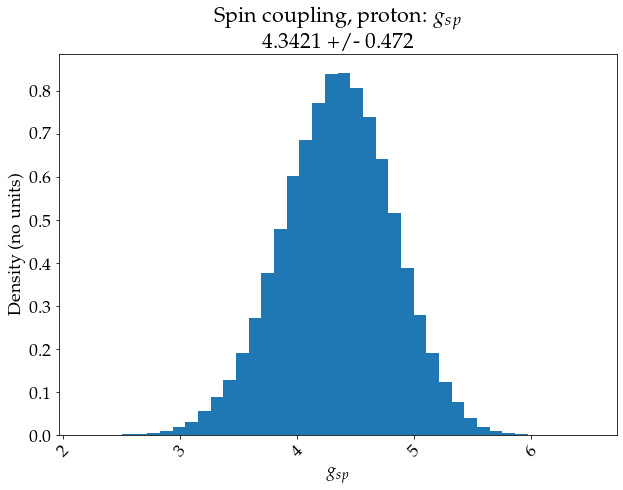

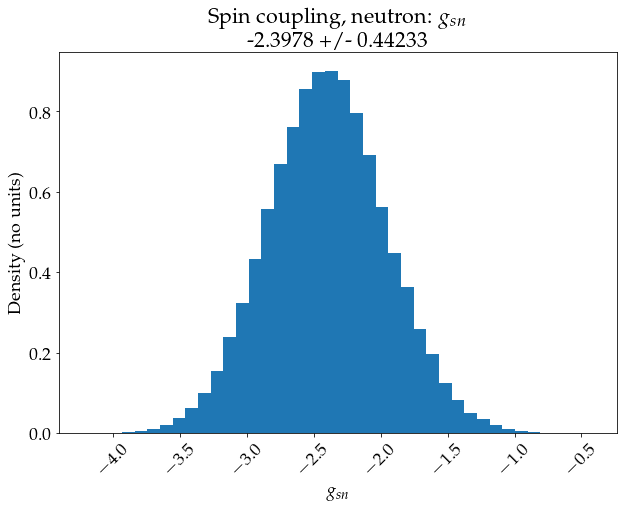

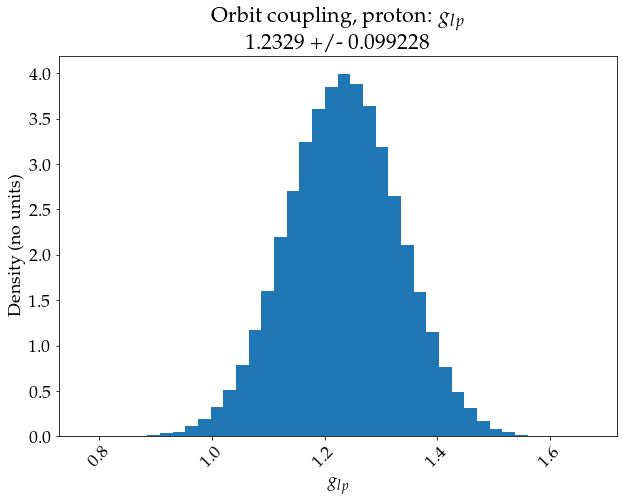

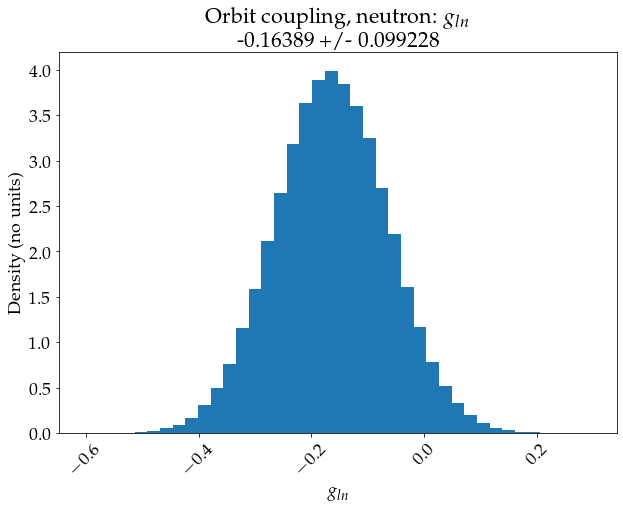

In [5]:
g_sp_low_limit = 2
g_sp_top_limit = 8
g_sn_low_limit = -5
g_sn_top_limit = 0
g_lp_low_limit = 0.75
g_lp_top_limit = 1.75

indices = (g_sp_trace > g_sp_low_limit) & (g_sp_trace < g_sp_top_limit) & (g_sn_trace > g_sn_low_limit) & (g_sn_trace < g_sn_top_limit) & (g_lp_trace > g_lp_low_limit) & (g_lp_trace < g_lp_top_limit)
 
g_sp_trace = g_sp_trace[indices]
g_sn_trace = g_sn_trace[indices]
g_lp_trace = g_lp_trace[indices]
g_ln_trace = g_ln_trace[indices]

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

cc = [[ 1.          0.3873855  -0.44327317  0.44327317]
 [ 0.3873855   1.          0.09803302 -0.09803302]
 [-0.44327317  0.09803302  1.         -1.        ]
 [ 0.44327317 -0.09803302 -1.          1.        ]]


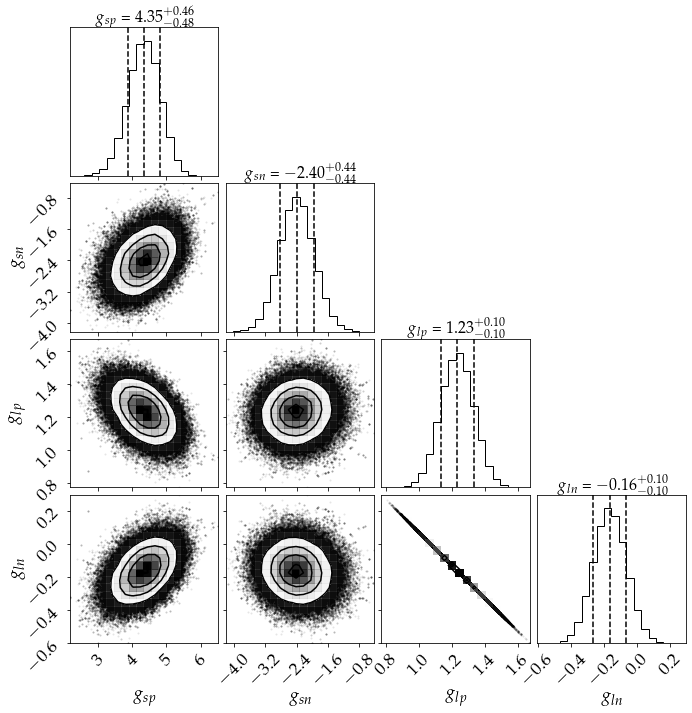

In [6]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T

f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

cc = [[ 1.          0.3873855  -0.44327317  0.44327317]
 [ 0.3873855   1.          0.09803302 -0.09803302]
 [-0.44327317  0.09803302  1.         -1.        ]
 [ 0.44327317 -0.09803302 -1.          1.        ]]


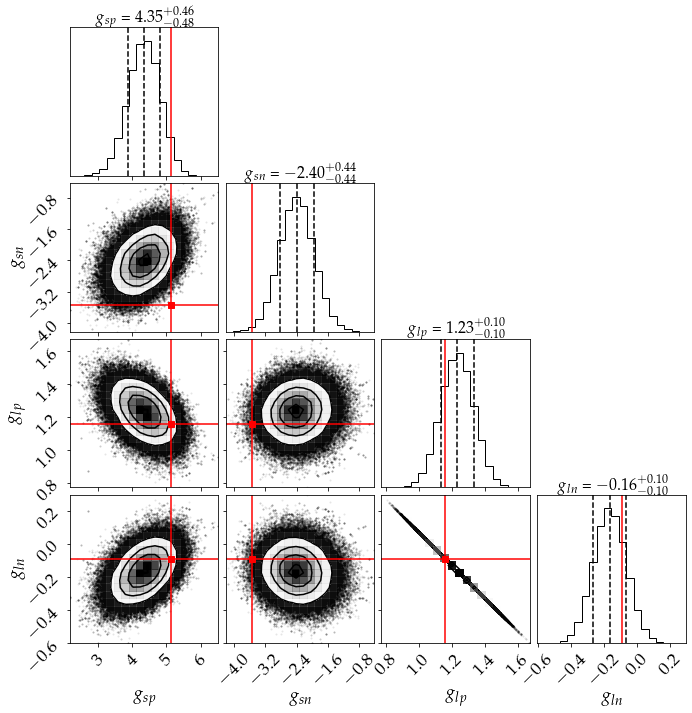

In [7]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T

g_list_brown = [g_sp_brown,g_sn_brown,g_lp_brown,g_ln_brown]

f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                       truths=g_list_brown, truth_color='red',truth_style='-.',
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

# v5.4 Gaussian priors, orbital isovector fixed

(3, 499200)


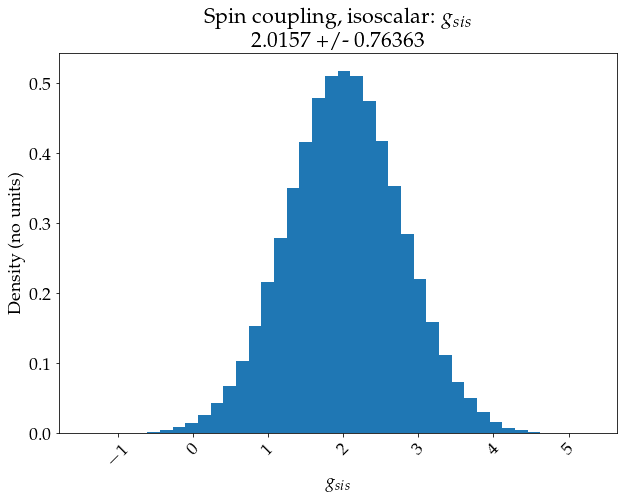

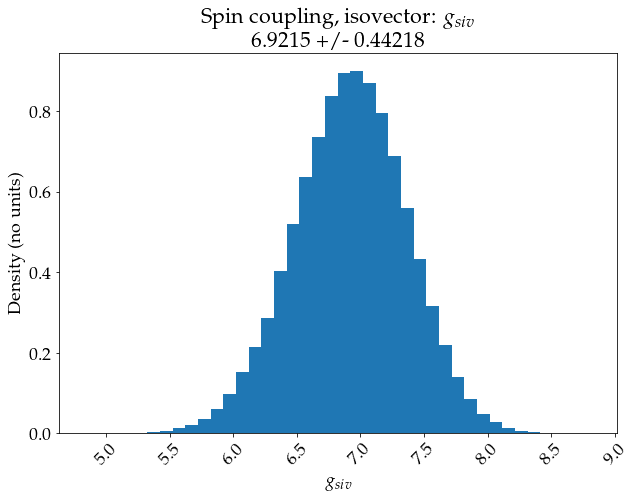

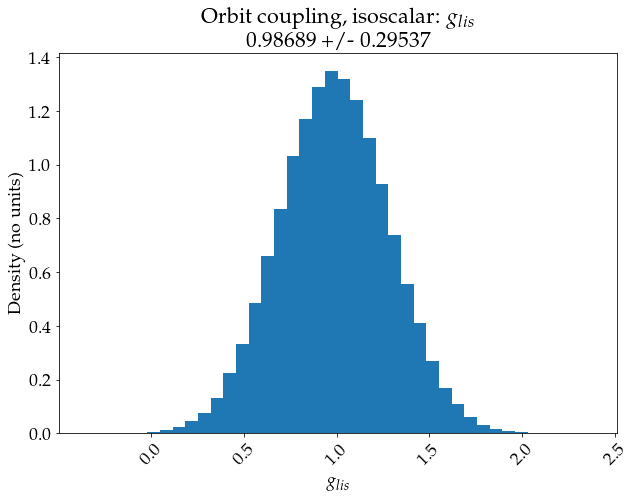

In [26]:
with open('traces_v5.4.pkl','rb') as fh:
    chain = pkl.load(fh)

# chain = [g_sis, g_siv, g_liv]
    
warmup = 400
chain = chain[:,warmup:,:]
chain = np.reshape(chain.T,(3,-1))
print(chain.shape)

g_sis_trace = chain[0].flatten()
g_siv_trace = chain[1].flatten()
g_lis_trace = chain[2].flatten()

make_hist(g_sis_trace,r'Spin coupling, isoscalar: $g_{sis}$',r'$g_{sis}$')
make_hist(g_siv_trace,r'Spin coupling, isovector: $g_{siv}$',r'$g_{siv}$')
make_hist(g_lis_trace,r'Orbit coupling, isoscalar: $g_{lis}$',r'$g_{lis}$')

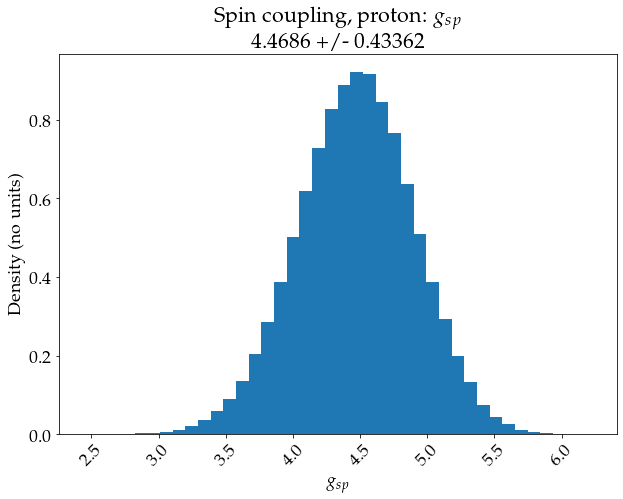

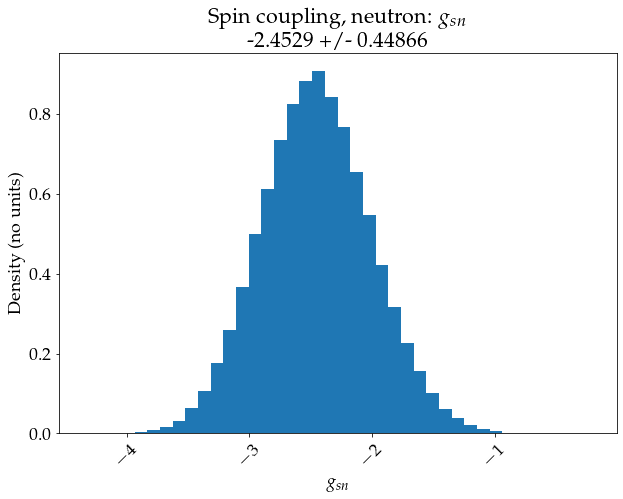

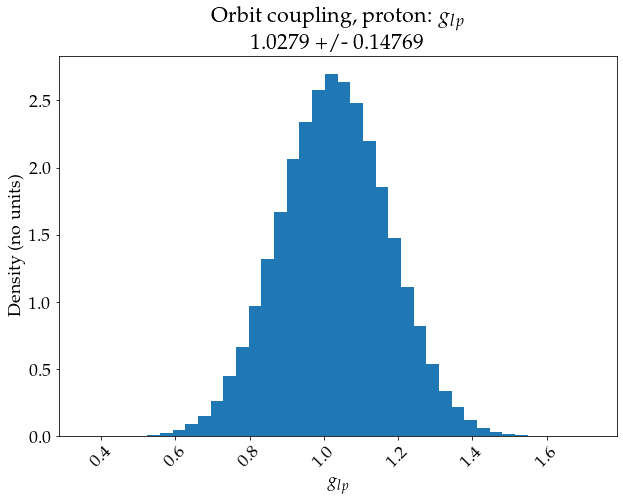

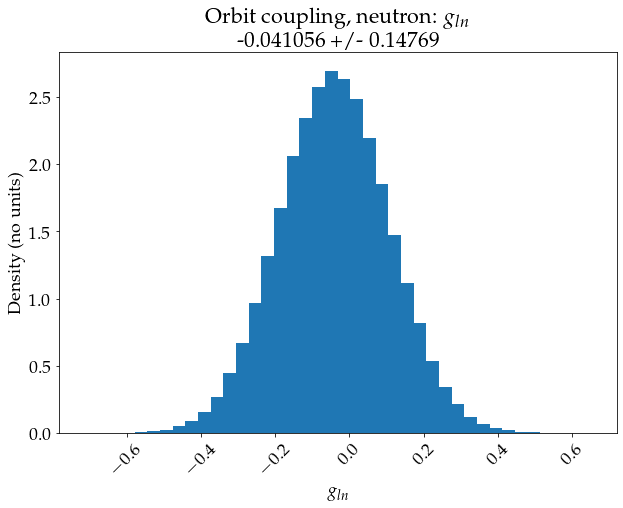

In [27]:
# take orbital isovector (liv) from Brown
g_sp_trace = 0.5*(g_sis_trace + g_siv_trace)
g_sn_trace = 0.5*(g_sis_trace - g_siv_trace)
g_lp_trace = 0.5*(g_lis_trace + g_liv_brown)
g_ln_trace = 0.5*(g_lis_trace - g_liv_brown)

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

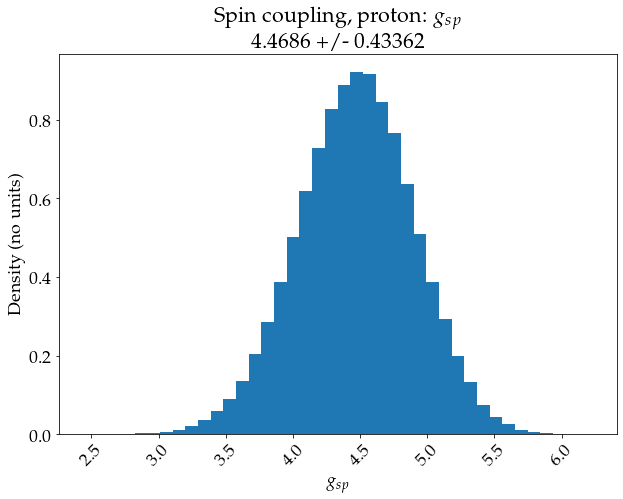

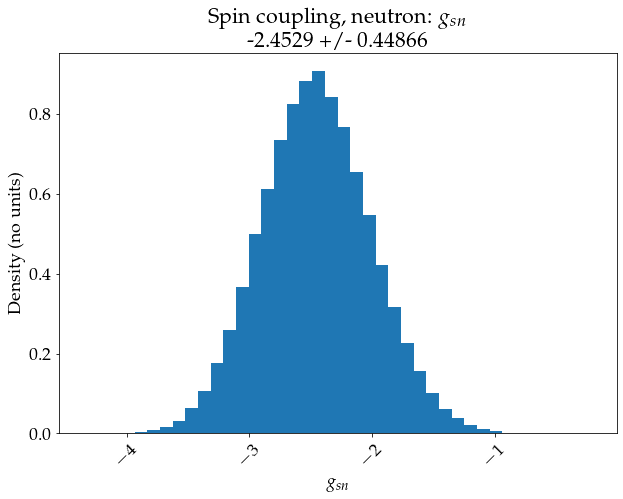

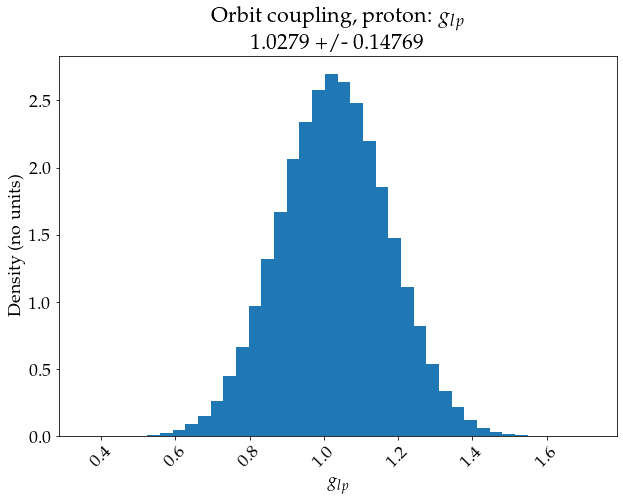

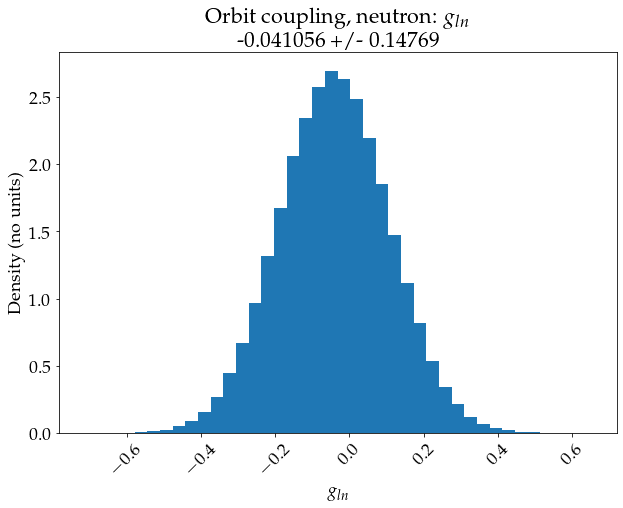

In [28]:
g_sp_low_limit = 2
g_sp_top_limit = 8
g_sn_low_limit = -6
g_sn_top_limit = 0

indices = (g_sp_trace > g_sp_low_limit) & (g_sp_trace < g_sp_top_limit)  
g_sp_trace = g_sp_trace[indices]
g_sn_trace = g_sn_trace[indices]
g_lp_trace = g_lp_trace[indices]
g_ln_trace = g_ln_trace[indices]

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

cc = [[1.         0.49808254 0.20030958 0.20030958]
 [0.49808254 1.         0.14277214 0.14277214]
 [0.20030958 0.14277214 1.         1.        ]
 [0.20030958 0.14277214 1.         1.        ]]


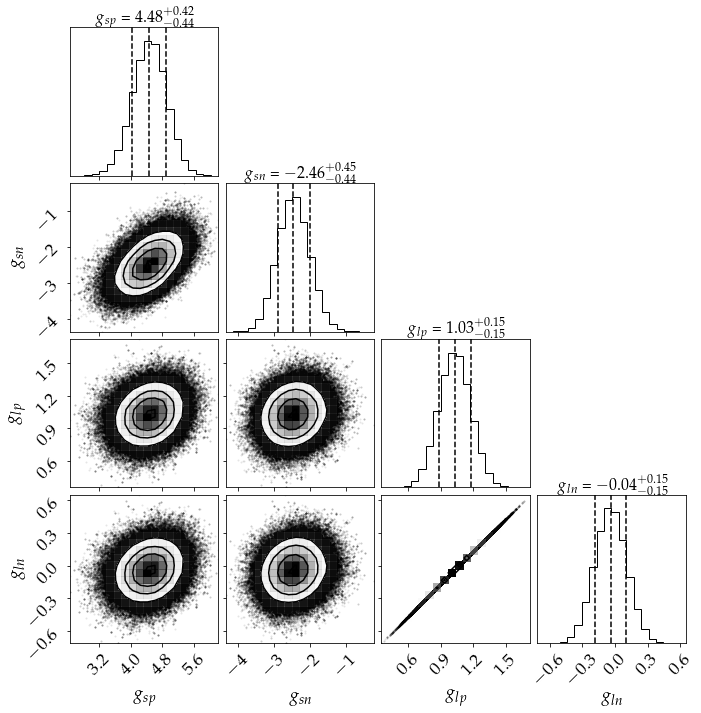

In [29]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T
f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

cc = [[1.         0.49808254 0.20030958 0.20030958]
 [0.49808254 1.         0.14277214 0.14277214]
 [0.20030958 0.14277214 1.         1.        ]
 [0.20030958 0.14277214 1.         1.        ]]


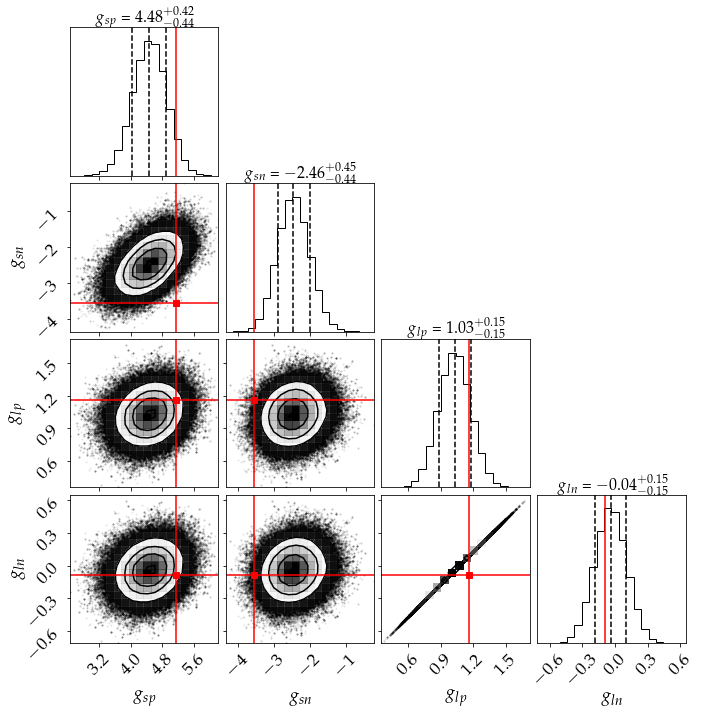

In [30]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T
f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                       truths=g_list_brown, truth_color='red',truth_style='-.',
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

# v5.5 : Spin isoscalar fixed

(3, 499200)


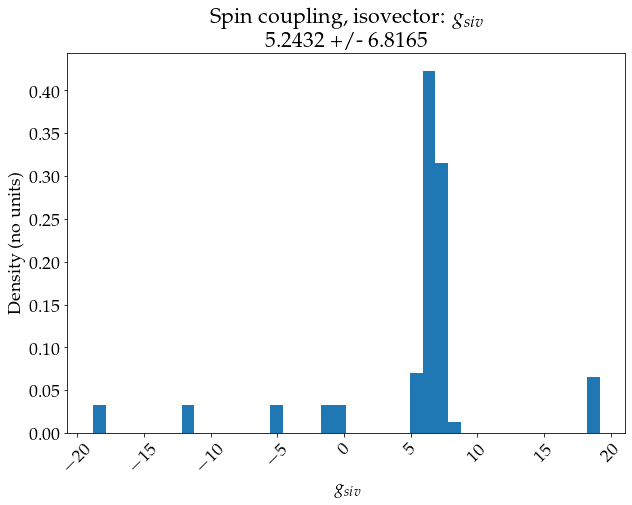

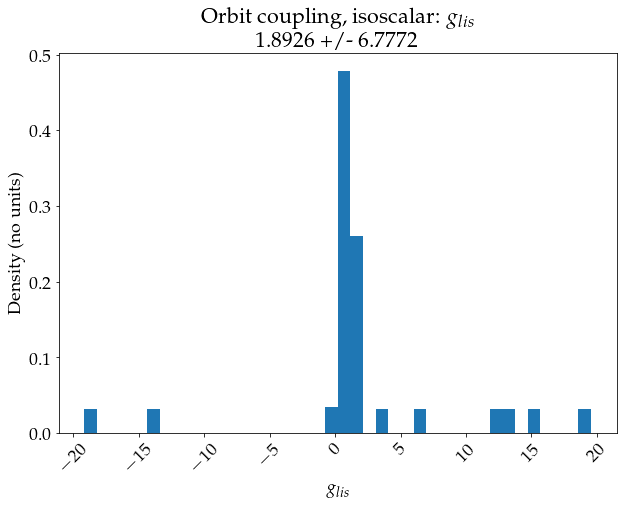

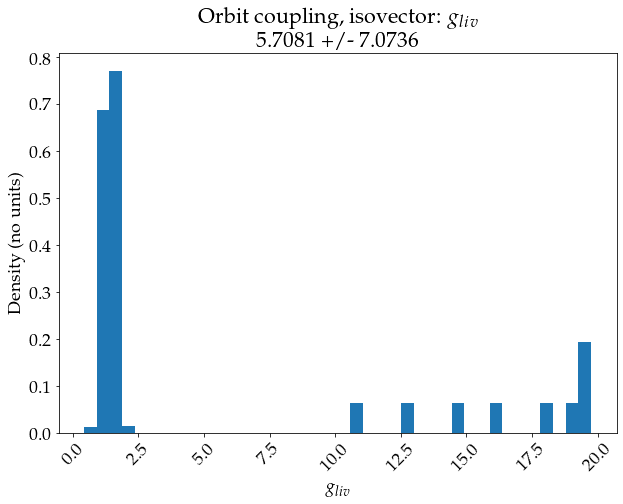

In [36]:
with open('traces_v5.5.pkl','rb') as fh:
    chain = pkl.load(fh)

warmup = 400
chain = chain[:,warmup:,:]
chain = np.reshape(chain.T,(3,-1))
print(chain.shape)

g_siv_trace = chain[0].flatten()
g_lis_trace = chain[1].flatten()
g_liv_trace = chain[2].flatten()

make_hist(g_siv_trace,r'Spin coupling, isovector: $g_{siv}$',r'$g_{siv}$')
make_hist(g_lis_trace,r'Orbit coupling, isoscalar: $g_{lis}$',r'$g_{lis}$')
make_hist(g_liv_trace,r'Orbit coupling, isovector: $g_{liv}$',r'$g_{liv}$')

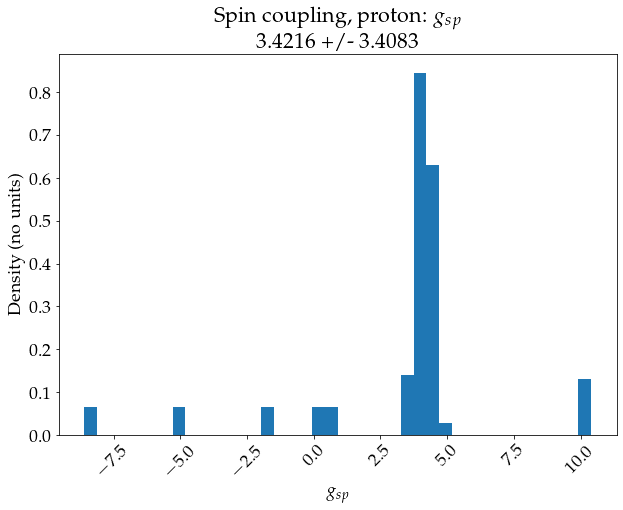

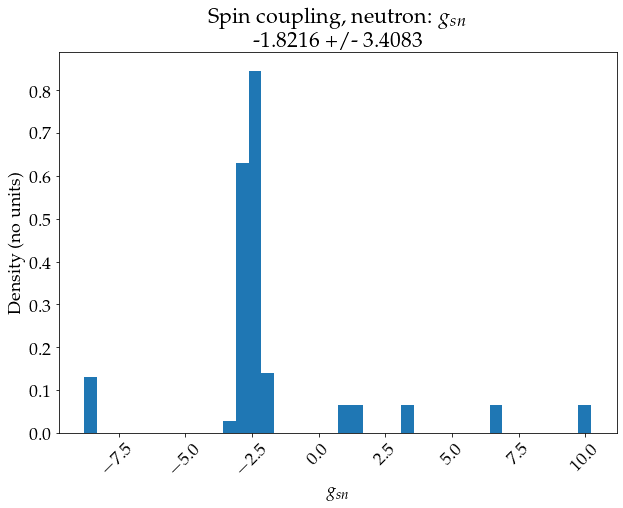

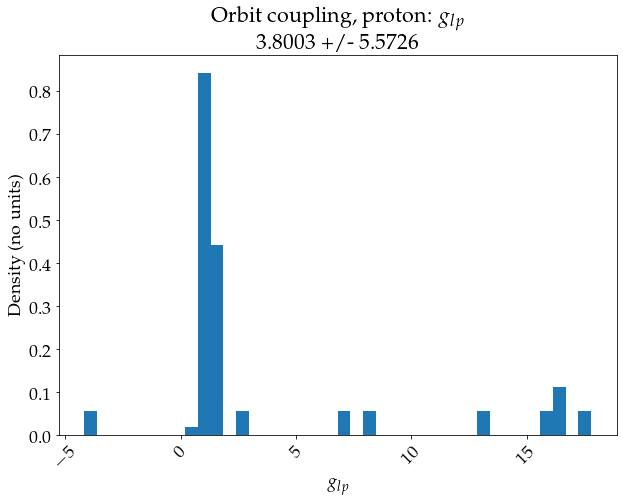

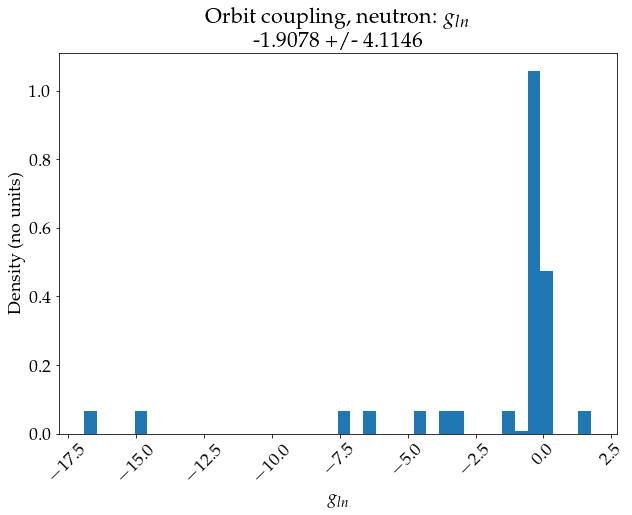

In [37]:
# take spin isoscalar (sis) from Brown
g_sp_trace = 0.5*(g_sis_brown + g_siv_trace)
g_sn_trace = 0.5*(g_sis_brown - g_siv_trace)
g_lp_trace = 0.5*(g_lis_trace + g_liv_trace)
g_ln_trace = 0.5*(g_lis_trace - g_liv_trace)

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

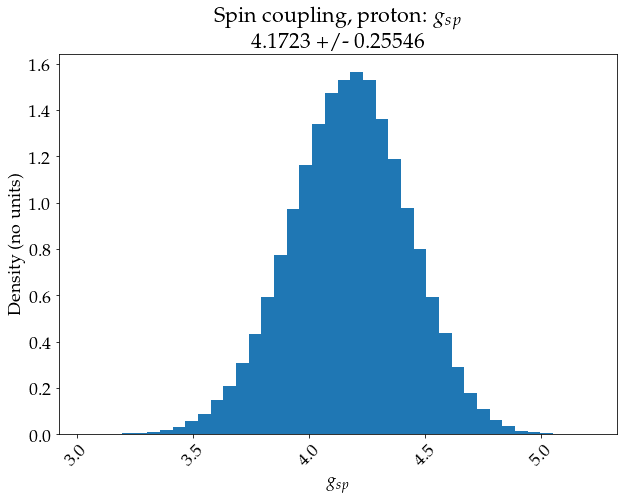

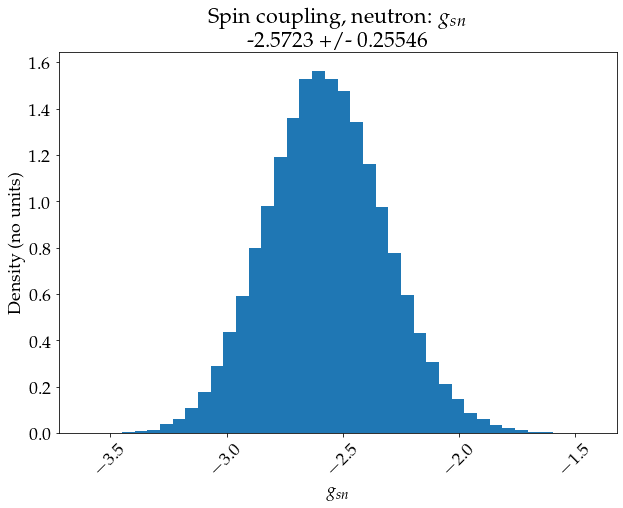

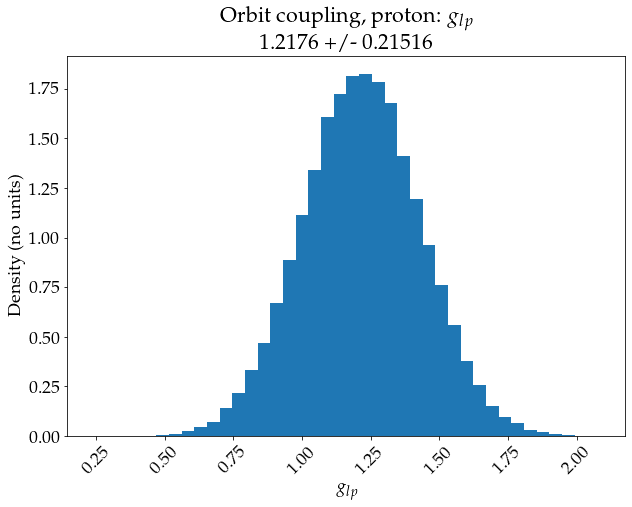

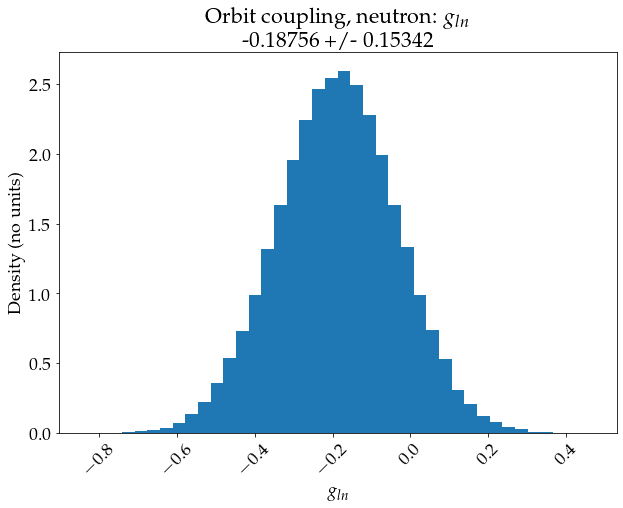

In [38]:
g_sp_low_limit = 2
g_sp_top_limit = 8
g_sn_low_limit = -5
g_sn_top_limit = 0
g_lp_low_limit = 0
g_lp_top_limit = 2.5

indices = (g_sp_trace > g_sp_low_limit) & (g_sp_trace < g_sp_top_limit) & (g_sn_trace > g_sn_low_limit) & (g_sn_trace < g_sn_top_limit) & (g_lp_trace > g_lp_low_limit) & (g_lp_trace < g_lp_top_limit)
 
g_sp_trace = g_sp_trace[indices]
g_sn_trace = g_sn_trace[indices]
g_lp_trace = g_lp_trace[indices]
g_ln_trace = g_ln_trace[indices]

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

cc = [[ 1.         -1.         -0.33758846  0.21152697]
 [-1.          1.          0.33758846 -0.21152697]
 [-0.33758846  0.33758846  1.          0.4055537 ]
 [ 0.21152697 -0.21152697  0.4055537   1.        ]]


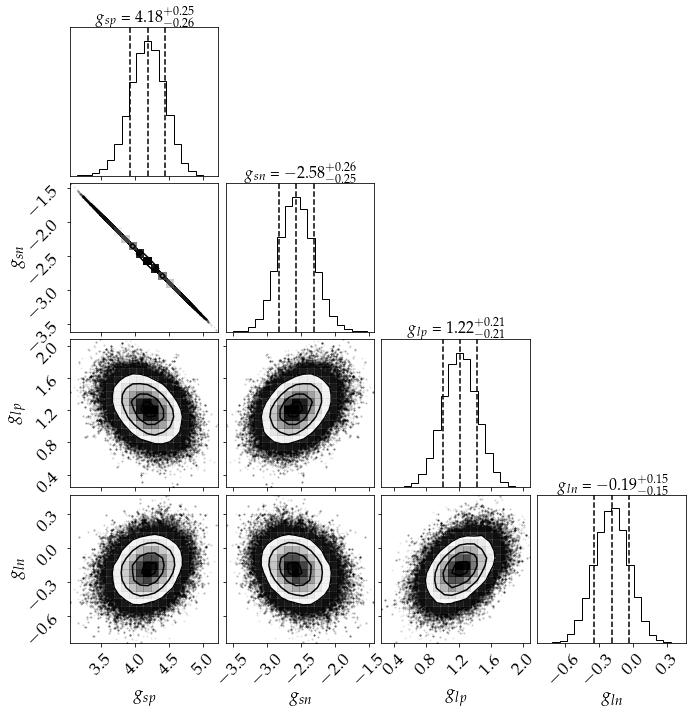

In [39]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T

f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

cc = [[ 1.         -1.         -0.33758846  0.21152697]
 [-1.          1.          0.33758846 -0.21152697]
 [-0.33758846  0.33758846  1.          0.4055537 ]
 [ 0.21152697 -0.21152697  0.4055537   1.        ]]


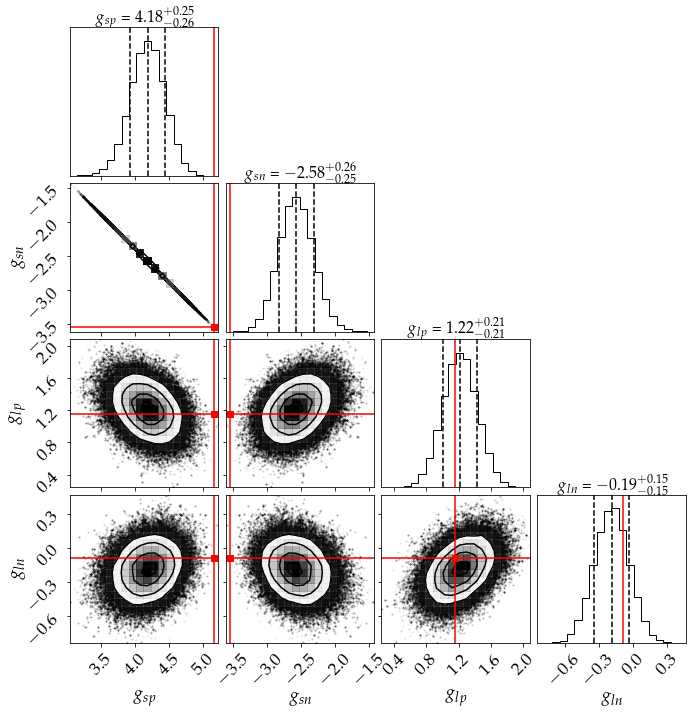

In [40]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T
f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                       truths=g_list_brown, truth_color='red',truth_style='-.',
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

# v5.6 : Spin isovector fixed

(3, 499200)


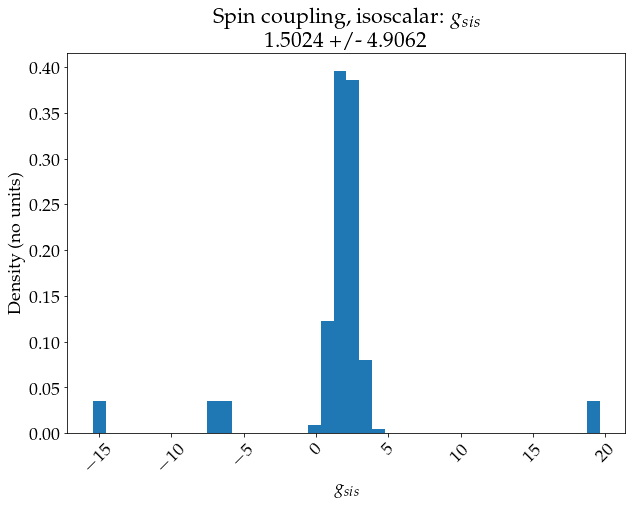

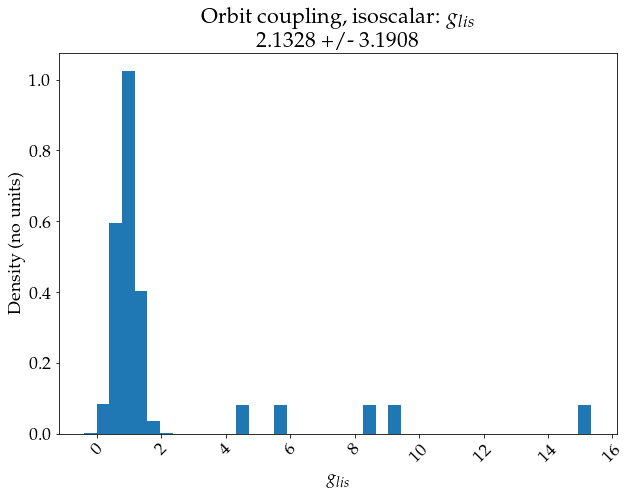

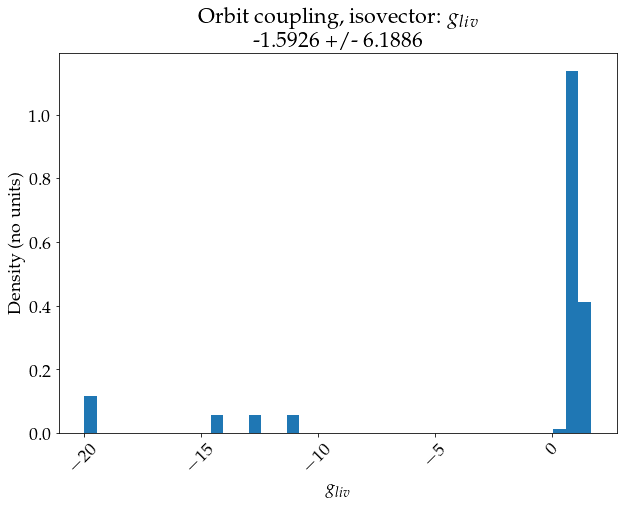

In [41]:
with open('traces_v5.6.pkl','rb') as fh:
    chain = pkl.load(fh)

warmup = 400
chain = chain[:,warmup:,:]
chain = np.reshape(chain.T,(3,-1))
print(chain.shape)

g_sis_trace = chain[0].flatten()
g_lis_trace = chain[1].flatten()
g_liv_trace = chain[2].flatten()

make_hist(g_sis_trace,r'Spin coupling, isoscalar: $g_{sis}$',r'$g_{sis}$')
make_hist(g_lis_trace,r'Orbit coupling, isoscalar: $g_{lis}$',r'$g_{lis}$')
make_hist(g_liv_trace,r'Orbit coupling, isovector: $g_{liv}$',r'$g_{liv}$')

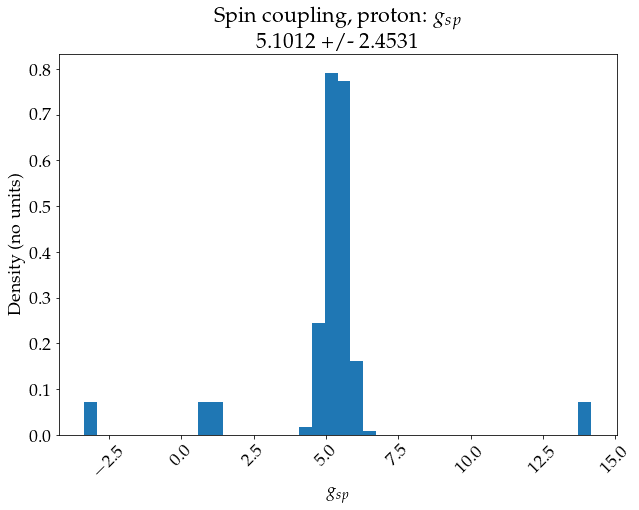

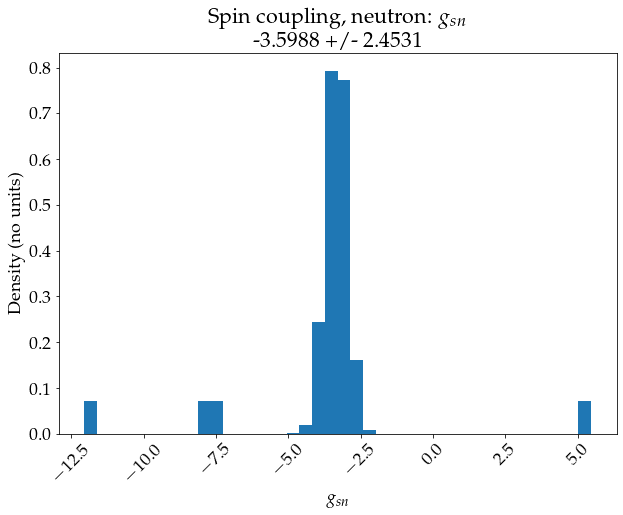

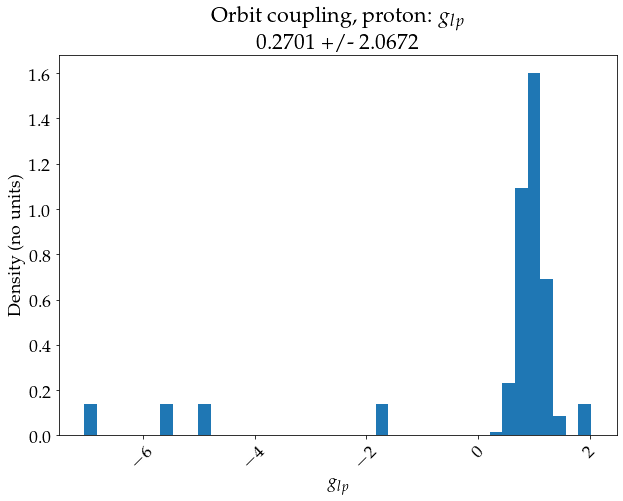

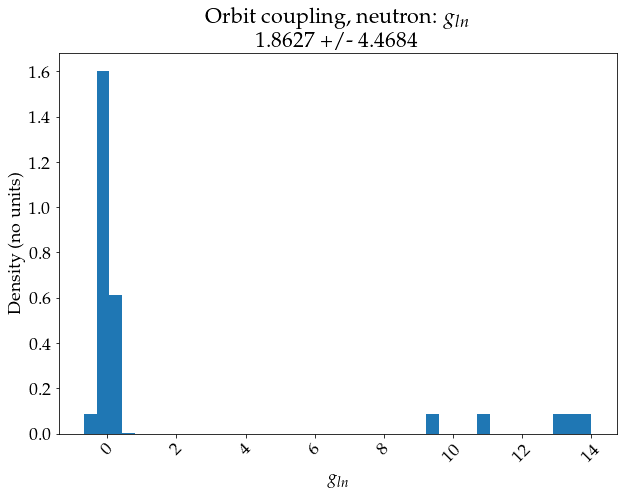

In [42]:
# take spin isoscalar (siv) from Brown
g_sp_trace = 0.5*(g_sis_trace + g_siv_brown)
g_sn_trace = 0.5*(g_sis_trace - g_siv_brown)
g_lp_trace = 0.5*(g_lis_trace + g_liv_trace)
g_ln_trace = 0.5*(g_lis_trace - g_liv_trace)

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

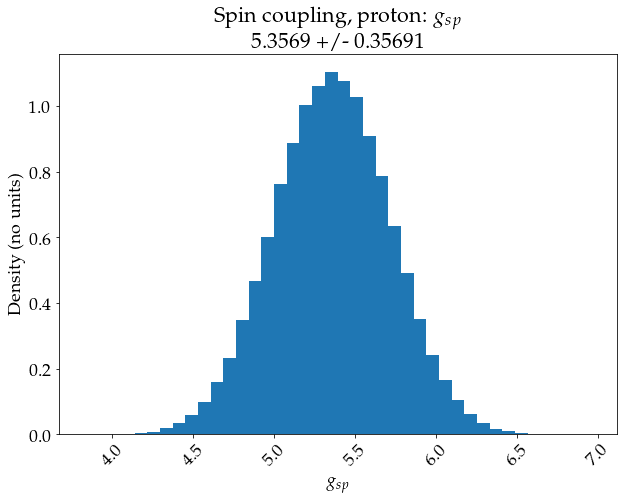

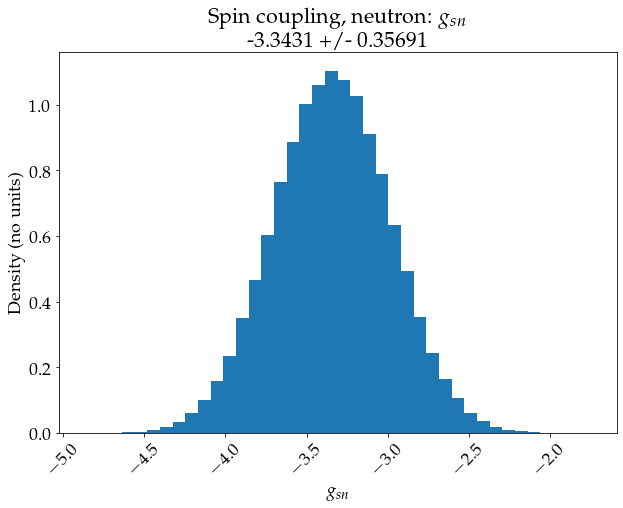

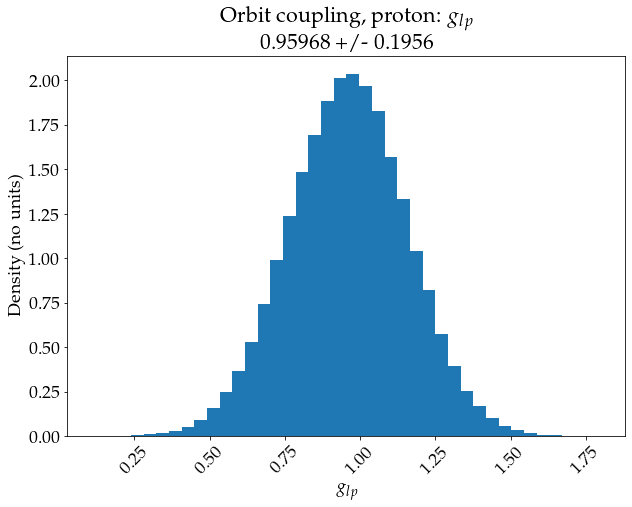

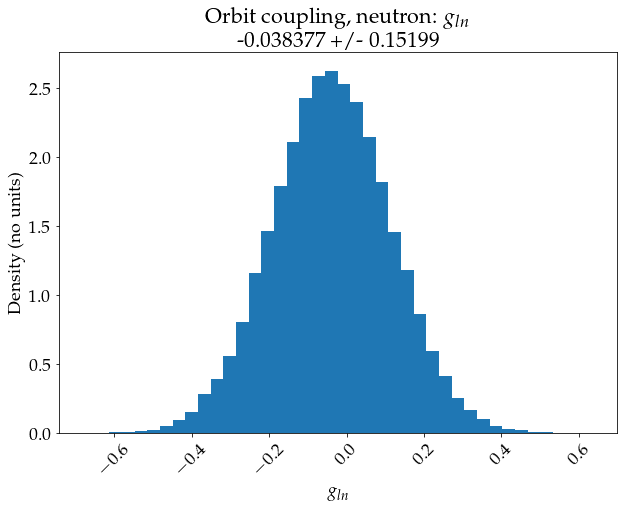

In [43]:
# g_sp_low_limit = 2
# g_sp_top_limit = 8
# g_sn_low_limit = -5
# g_sn_top_limit = 0
g_lp_low_limit = 0
g_lp_top_limit = 2
g_ln_low_limit = -1
g_ln_top_limit = 1

indices = (g_lp_trace > g_lp_low_limit) & (g_lp_trace < g_lp_top_limit) & (g_ln_trace > g_ln_low_limit) & (g_ln_trace < g_ln_top_limit)
g_sp_trace = g_sp_trace[indices]
g_sn_trace = g_sn_trace[indices]
g_lp_trace = g_lp_trace[indices]
g_ln_trace = g_ln_trace[indices]

make_hist(g_sp_trace,r'Spin coupling, proton: $g_{sp}$',r'$g_{sp}$')
make_hist(g_sn_trace,r'Spin coupling, neutron: $g_{sn}$',r'$g_{sn}$')
make_hist(g_lp_trace,r'Orbit coupling, proton: $g_{lp}$',r'$g_{lp}$')
make_hist(g_ln_trace,r'Orbit coupling, neutron: $g_{ln}$',r'$g_{ln}$')

cc = [[1.         1.         0.12347664 0.30232306]
 [1.         1.         0.12347664 0.30232306]
 [0.12347664 0.12347664 1.         0.53732884]
 [0.30232306 0.30232306 0.53732884 1.        ]]


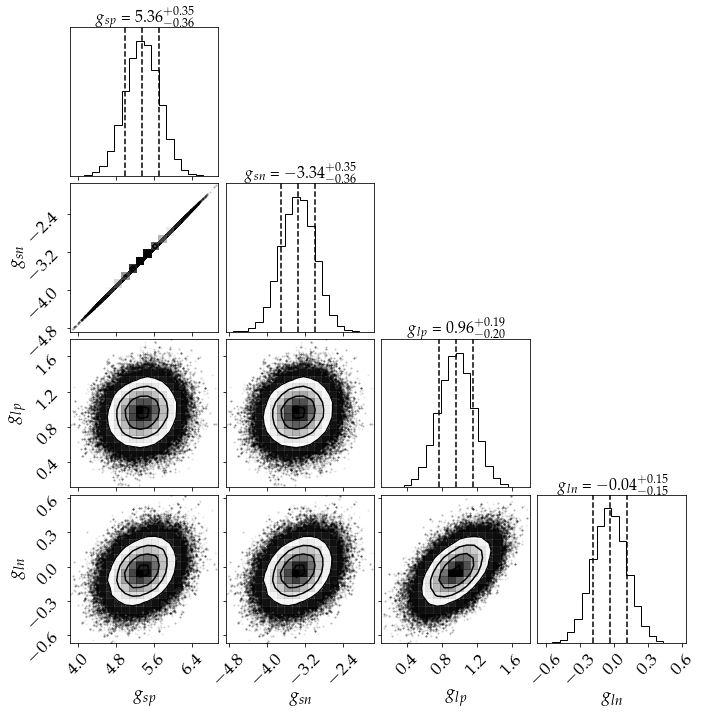

In [44]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T
f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')

cc = [[1.         1.         0.12347664 0.30232306]
 [1.         1.         0.12347664 0.30232306]
 [0.12347664 0.12347664 1.         0.53732884]
 [0.30232306 0.30232306 0.53732884 1.        ]]


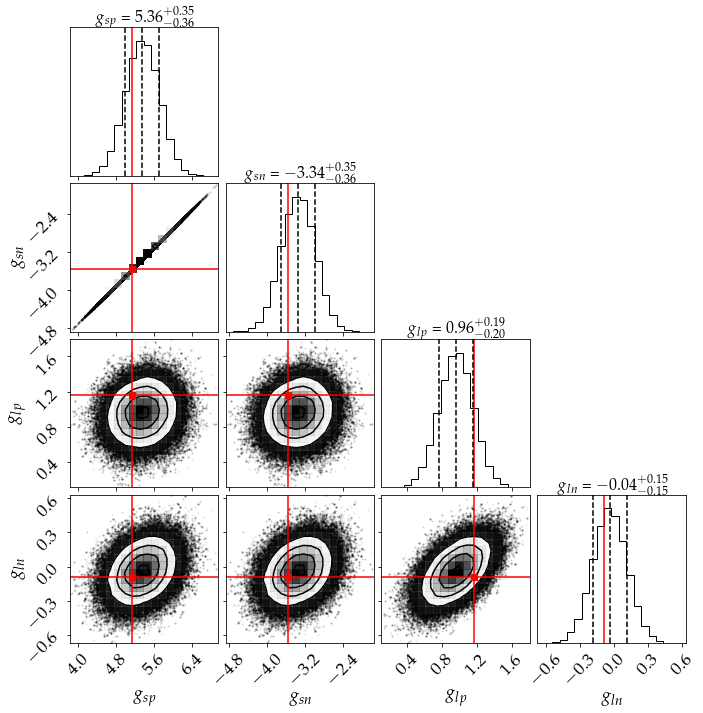

In [45]:
data = np.array([g_sp_trace.flatten(),g_sn_trace.flatten(),g_lp_trace.flatten(),g_ln_trace.flatten()]).T
f = plt.figure(figsize=(10,10))
figure = corner.corner(data,
                       labels=[r'$g_{sp}$',r'$g_{sn}$',r'$g_{lp}$',r'$g_{ln}$'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 16},
                       truths=g_list_brown, truth_color='red',truth_style='-.',
                      fig=f)

print(f'cc = {np.corrcoef(data.T)}')